## This notebook illustrates every step of the process of training models for ic labeling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)
import pandas as pd

%matplotlib inline

First of all, we need the dataset. We can download and it using the following commands.

Now, we load the dataset. For this we use the special function, which reads the csv-files from the directory and puts the data in a convenient format.

In [2]:
from alice_ml.preprocessing import load_dataset


pathes = {'mu_rhythm1': './dataset_mu_rhythm_1.1',
          'mu_rhythm2': './beliaevaaleksandra/Downloads/dataset_mu_rhythm_2_1.2',
          'asd': './beliaevaaleksandra/Downloads/dataset_mu_asd_10.0'} 

data, raw_annotations = {}, {}

for ds_name, path in pathes.items():
    data[ds_name], raw_annotations[ds_name] = load_dataset(path, preload=False)

In [3]:
! mne --version

MNE 0.23.4


Now, we calculate features for each ic in the dataset.

In [ ]:
from alice_ml.features import build_feature_df

features = {}

for ds_name, ds_data in data.items():
    features[ds_name] = build_feature_df(ds_data)
    features[ds_name].fillna(-1, inplace=True)

features['asd']

features['mu_rhythm1'].to_csv('features_mu_rhythm1.csv')
features['mu_rhythm2'].to_csv('features_mu_rhythm2.csv')
features['asd'].to_csv('features_asd.csv')

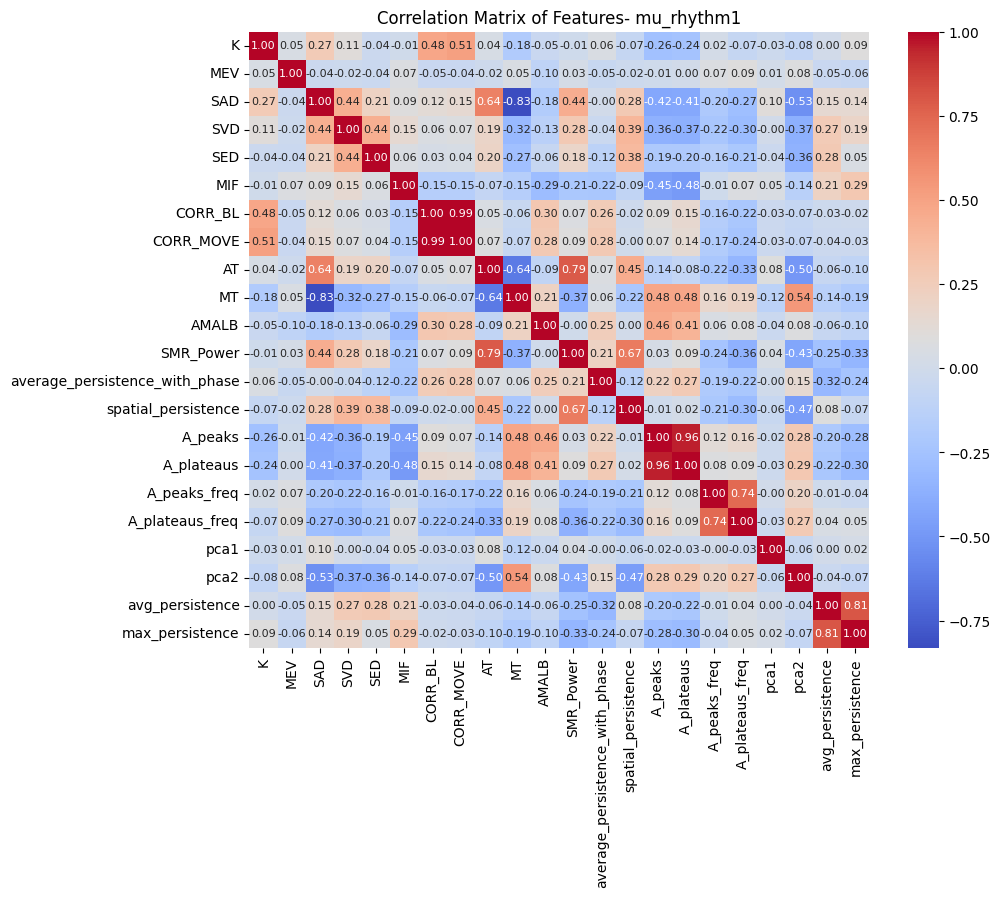

In [5]:
import seaborn as sns
import os
# Computing the correlation matrix
correlation_matrix = features['mu_rhythm1'].corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title(f'Correlation Matrix of Features- mu_rhythm1')
plt.show()



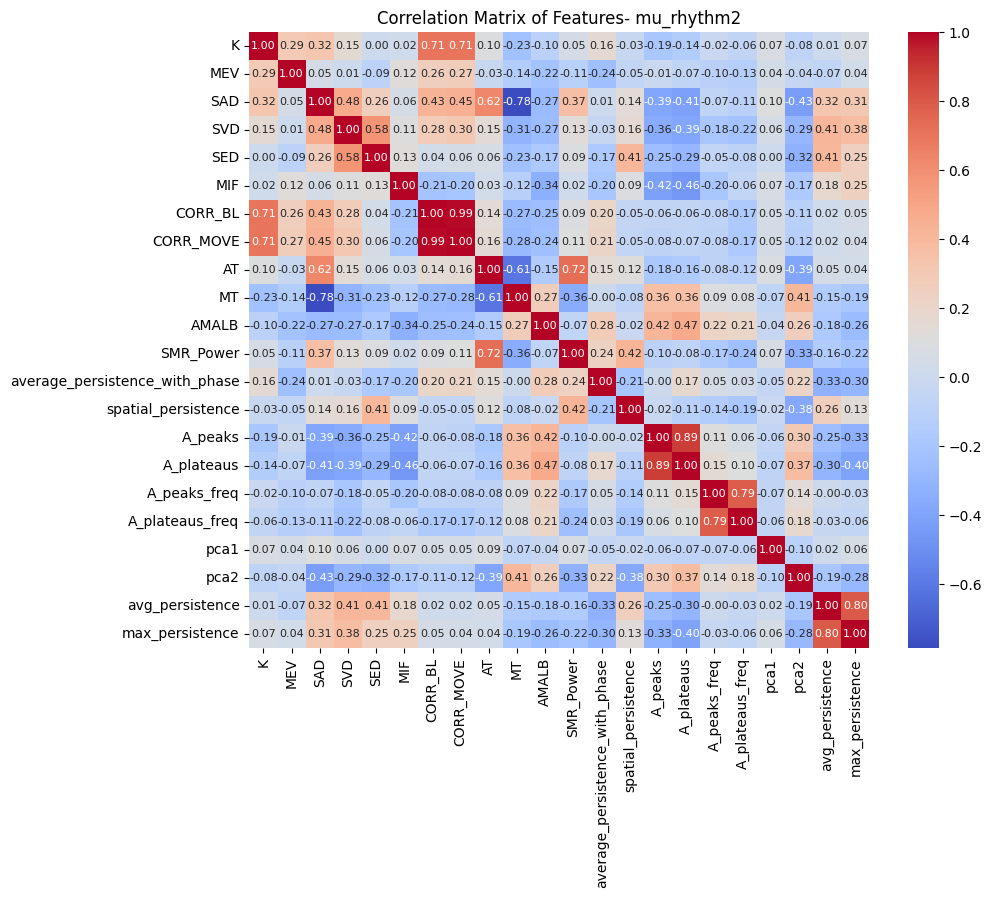

In [6]:
import seaborn as sns
import os
# Computing the correlation matrix
correlation_matrix = features['mu_rhythm2'].corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title(f'Correlation Matrix of Features- mu_rhythm2')
plt.show()


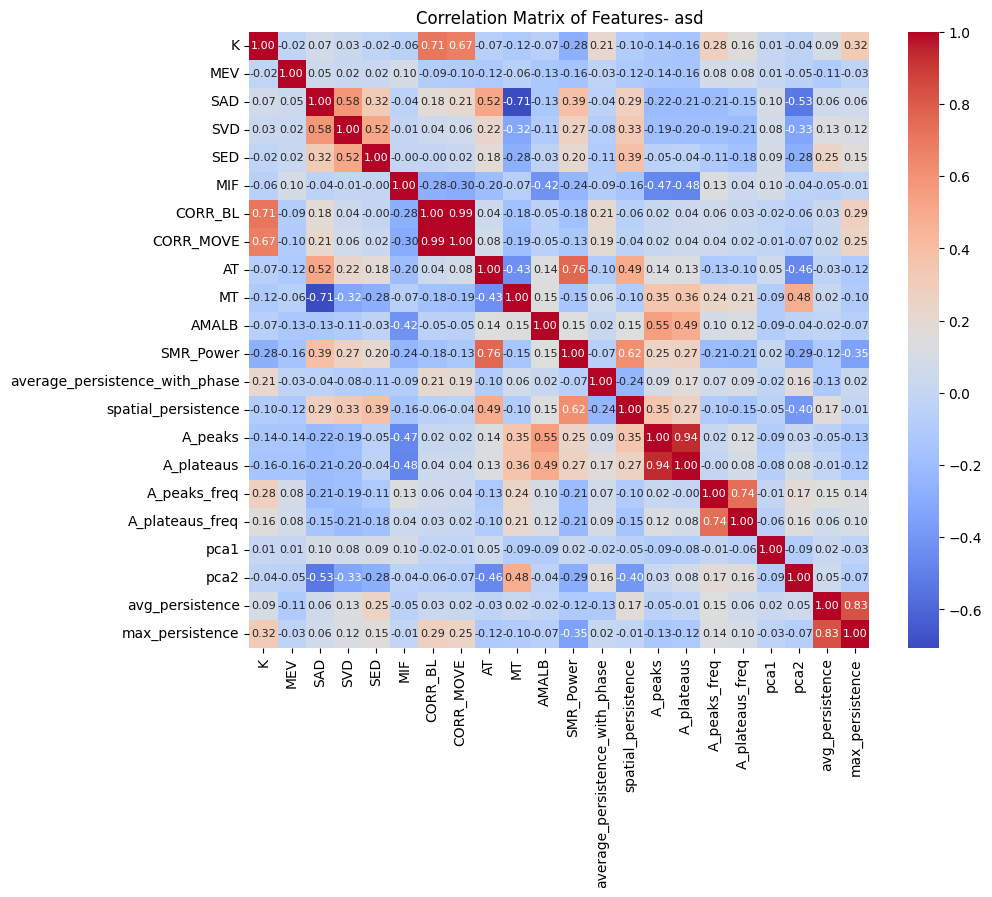

In [7]:
import seaborn as sns
import os
# Computing the correlation matrix
correlation_matrix = features['asd'].corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title(f'Correlation Matrix of Features- asd')
plt.show()


Targets are calculated as the average of the answers of multiple experts for each ic.

In [8]:
def propogate_labels(annotations):
    return annotations.assign(flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_line_noise'])

annotations = {}

for ds_name, ds_raw_annotations in raw_annotations.items():
    annotations[ds_name] = propogate_labels(ds_raw_annotations)

For now we do not want to distinguish between eye movement types, so we unite them under `'flag_eyes'`. We also presume the positive label for `'flag_alpha'` or `'flag_mu'` implies the positive label for `'flag_brain'`. Finally, since we do not have sufficient data for distinguishing line noise, we will not consider this flag.

In order to get binary labels we apply threshold to these averages. By default, the each label has weight $\frac{1}{n}$, where $n$ is the number of labels given to the ic by this expert. We set the threshold to $0.33$ For flags `alpha` and `mu` we choose a simpler approach: each label has weight $1$. The threshold in this case is equal to $0.5$.

In [9]:
from alice_ml.preprocessing import build_target_df
targets = {}

for ds_name, ds_annotations in annotations.items():
    targets[ds_name] = build_target_df(ds_annotations, weights='uniform', 
                                       strategy='mean', threshold=0.33)

    targets[ds_name][['flag_alpha', 'flag_mu', 'flag_heart']] =\
        build_target_df(ds_annotations, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')

    targets[ds_name] = targets[ds_name].loc[:, (targets[ds_name].mean(axis=0) > 0.05) 
                                            & (targets[ds_name].all(axis=0) < 0.95)]

In [10]:
targets['asd'][targets['asd'].flag_alpha==True].count(), len(targets['asd'])

(flag_alpha    11
 flag_mu       11
 dtype: int64,
 22)

In [11]:
targets['asd']

,flag_alpha,flag_mu
ic_id,,
IC002491,True,False
IC002513,False,True
IC002515,False,True
IC002522,True,False
IC002532,True,False
IC002533,False,True
IC002537,False,True
IC002561,False,True
IC002588,True,False


In [12]:
mu_rhythm_features = pd.concat([features['mu_rhythm1'],
                                      features['mu_rhythm2']])
mu_rhythm_targets = pd.concat([targets['mu_rhythm1'],
                               targets['mu_rhythm2']])

In [13]:
mu_rhythm_features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001181,2.394026,14.074256,0.350957,0.020189,0.030888,0.226681,0.027488,0.031416,0.147364,-0.122794,...,1.429672,0.144175,0.074022,0.175978,9.265428,8.293834,0.099706,-0.285821,0.027365,0.228620
IC001182,-0.202781,78.412312,0.060472,0.002325,0.053063,0.218715,0.004291,0.004950,0.183362,-0.025954,...,1.340806,0.121335,0.107542,0.347765,8.435934,7.632316,0.046863,-0.244263,0.023887,0.144346
IC001183,0.217014,137.248558,0.052225,-0.002635,0.065720,0.311969,0.003769,0.005342,0.074177,-0.027691,...,1.292065,0.068231,0.093575,0.117318,9.645950,9.558845,0.156498,-0.229528,0.013144,0.036473
IC001184,1.983181,74.136798,-0.192816,-0.020441,0.088582,0.246820,0.001432,0.001503,-0.127449,0.156610,...,1.230299,0.076154,0.067039,0.076816,10.576282,10.707148,-0.236639,0.306388,0.034190,0.140988
IC001185,0.035117,180.334305,-0.142686,-0.013640,0.000192,0.308996,0.004359,0.004855,0.020297,0.144126,...,1.295255,0.089498,0.479050,0.671788,9.926716,9.512111,0.090920,-0.394789,0.018630,0.079815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC002247,-0.346051,1.958688,-0.138244,-0.035329,0.057946,0.067928,0.001614,0.001880,-0.086473,0.151316,...,1.277897,0.181658,0.541841,0.820084,9.775486,9.484000,-0.381393,0.126716,0.038603,0.327550
IC002263,-0.205886,3.138964,0.049312,0.013636,0.335032,0.381675,0.000466,0.000479,0.030966,0.110267,...,0.844700,0.384775,0.048117,0.058577,9.283666,9.016977,0.047274,-0.246131,0.043289,0.209863
IC002279,-0.411610,2.644481,-0.040728,0.001176,0.089518,0.523113,0.000143,0.000312,0.085879,0.092183,...,1.163437,0.061526,0.022727,0.026860,10.508146,10.480193,-0.147122,-0.291740,0.055151,0.771891
IC002295,2.202804,23.556981,-0.039008,0.001592,0.084574,0.134651,0.012137,0.014126,0.012094,0.022385,...,1.290464,0.027893,0.314763,0.440111,9.401140,9.454178,0.082093,-0.421929,0.009435,0.105446


In [14]:
mu_rhythm_features = mu_rhythm_features.loc[mu_rhythm_targets.index]

In [15]:
mu_alpha_index =  list(targets['asd'].index)
other_index = [ica for ica in list(features['asd'].index) if ica not in mu_alpha_index]
index_train = mu_alpha_index[:int(len(mu_alpha_index)*0.3)]+other_index[:int(len(other_index)*0.3)]
index_test = mu_alpha_index[int(len(mu_alpha_index)*0.3):]+other_index[int(len(other_index)*0.3):]
targets_ads_train = pd.DataFrame(data=np.zeros([len(index_train),2]).astype(bool),
          index=index_train,
          columns=['flag_alpha','flag_mu'])
targets_ads_test = pd.DataFrame(data=np.zeros([len(index_test),2]).astype(bool),
          index=index_test,
          columns=['flag_alpha','flag_mu'])
targets_ads_train.loc[mu_alpha_index[:int(len(mu_alpha_index)*0.3)]] = targets['asd'].loc[mu_alpha_index[:int(len(mu_alpha_index)*0.3)]]
targets_ads_test.loc[mu_alpha_index[int(len(mu_alpha_index)*0.3):]] = targets['asd'].loc[mu_alpha_index[int(len(mu_alpha_index)*0.3):]]


mu_rhythm_features_all = pd.concat([mu_rhythm_features,
                                      features['asd'].loc[index_train]])
mu_rhythm_targets_all = pd.concat([mu_rhythm_targets,
                               targets_ads_train])

In [16]:
targets_ads = pd.DataFrame(data=np.zeros([features['asd'].shape[0],2]).astype(bool),
          index=features['asd'].index,
          columns=['flag_alpha','flag_mu'])
targets_ads.loc[targets['asd'].index] = targets['asd']

In [17]:
targets_ads

,flag_alpha,flag_mu
IC002497,False,False
IC002513,False,True
IC002528,False,False
IC002544,False,False
IC002560,False,False
...,...,...
IC002639,False,False
IC002651,False,True
IC002667,False,False
IC002683,False,False


In [18]:
targets_ads_test

,flag_alpha,flag_mu
IC002537,False,True
IC002561,False,True
IC002588,True,False
IC002589,False,True
IC002597,True,False
...,...,...
IC002607,False,False
IC002639,False,False
IC002667,False,False
IC002683,False,False


/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_90074/1484017396.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Label', y='avg_persistence', palette=palette)


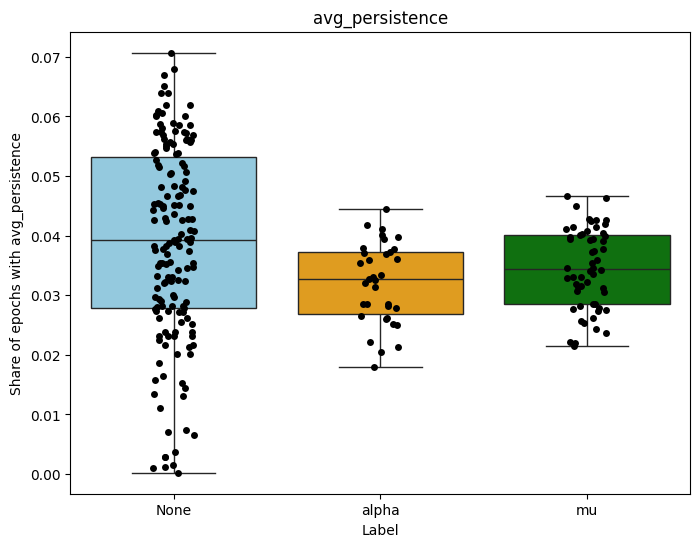

In [19]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import os

# Установим фиксированный seed для случайных чисел
np.random.seed(42)

# Загрузим данные (замени путь на свой)
# features = pd.read_csv('path_to_features.csv', index_col=0)
# targets = pd.read_csv('path_to_targets.csv', index_col=0)

# Соединим датафреймы по индексу
merged_df = mu_rhythm_features_all.join(mu_rhythm_targets_all, how='inner')

# Создадим новый столбец 'Label' для отображения категорий
merged_df['Label'] = 'None'
merged_df.loc[merged_df['flag_alpha'] == True, 'Label'] = 'alpha'
merged_df.loc[merged_df['flag_mu'] == True, 'Label'] = 'mu'

# Определим палитру цветов для каждого боксплота
palette = {"None": "skyblue", "alpha": "orange", "mu": "green"}

# Построим боксплот с разными цветами для каждой категории
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='Label', y='avg_persistence', palette=palette)
sns.stripplot(data=merged_df, x='Label', y='avg_persistence', color='black', jitter=True, dodge=True)
plt.title(f'avg_persistence')
plt.xlabel('Label')
plt.ylabel('Share of epochs with avg_persistence')
plt.show()


/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_90074/1347968455.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Label', y='max_persistence', palette=palette)


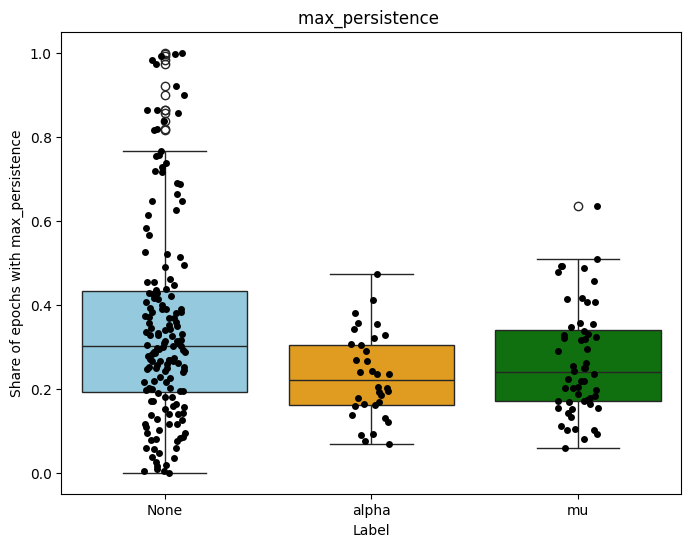

In [20]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import os

# Установим фиксированный seed для случайных чисел
np.random.seed(42)

# Загрузим данные (замени путь на свой)
# features = pd.read_csv('path_to_features.csv', index_col=0)
# targets = pd.read_csv('path_to_targets.csv', index_col=0)


# Соединим датафреймы по индексу
merged_df = mu_rhythm_features_all.join(mu_rhythm_targets_all, how='inner')

# Создадим новый столбец 'Label' для отображения категорий
merged_df['Label'] = 'None'
merged_df.loc[merged_df['flag_alpha'] == True, 'Label'] = 'alpha'
merged_df.loc[merged_df['flag_mu'] == True, 'Label'] = 'mu'

# Определим палитру цветов для каждого боксплота
palette = {"None": "skyblue", "alpha": "orange", "mu": "green"}

# Построим боксплот с разными цветами для каждой категории
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='Label', y='max_persistence', palette=palette)
sns.stripplot(data=merged_df, x='Label', y='max_persistence', color='black', jitter=True, dodge=True)
plt.title(f'max_persistence ')
plt.xlabel('Label')
plt.ylabel('Share of epochs with max_persistence')
plt.show()

/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_90074/900171072.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Label', y='spatial_persistence', palette=palette)


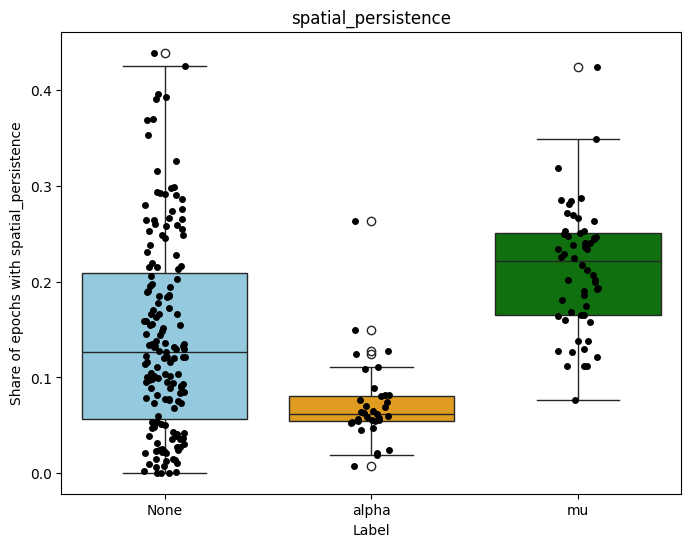

In [21]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import os

# Установим фиксированный seed для случайных чисел
np.random.seed(42)

# Загрузим данные (замени путь на свой)
# features = pd.read_csv('path_to_features.csv', index_col=0)
# targets = pd.read_csv('path_to_targets.csv', index_col=0)


# Соединим датафреймы по индексу
merged_df = mu_rhythm_features_all.join(mu_rhythm_targets_all, how='inner')

# Создадим новый столбец 'Label' для отображения категорий
merged_df['Label'] = 'None'
merged_df.loc[merged_df['flag_alpha'] == True, 'Label'] = 'alpha'
merged_df.loc[merged_df['flag_mu'] == True, 'Label'] = 'mu'

# Определим палитру цветов для каждого боксплота
palette = {"None": "skyblue", "alpha": "orange", "mu": "green"}

# Построим боксплот с разными цветами для каждой категории
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='Label', y='spatial_persistence', palette=palette)
sns.stripplot(data=merged_df, x='Label', y='spatial_persistence', color='black', jitter=True, dodge=True)
plt.title(f'spatial_persistence')
plt.xlabel('Label')
plt.ylabel('Share of epochs with spatial_persistence')
plt.show()

/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_90074/1210308741.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Label', y='SMR_Power', palette=palette)


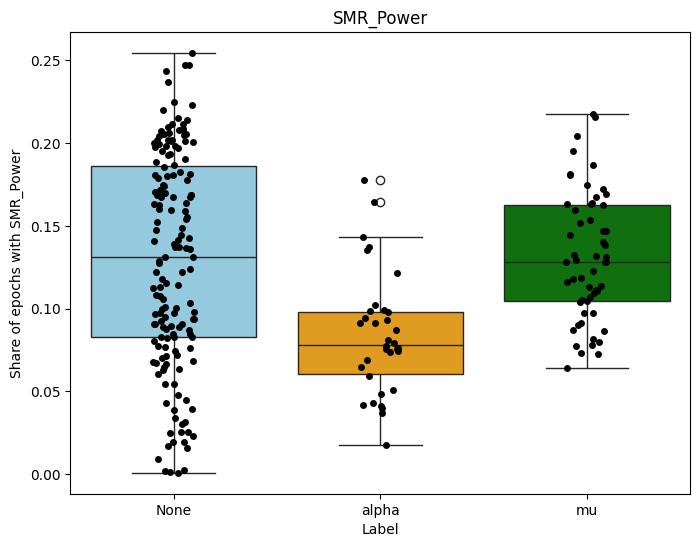

In [22]:
import seaborn as sns
import pandas as pd
import seaborn as sns

# Установим фиксированный seed для случайных чисел
np.random.seed(42)

# Загрузим данные (замени путь на свой)
# features = pd.read_csv('path_to_features.csv', index_col=0)
# targets = pd.read_csv('path_to_targets.csv', index_col=0)

# Соединим датафреймы по индексу
merged_df = mu_rhythm_features_all.join(mu_rhythm_targets_all, how='inner')

# Создадим новый столбец 'Label' для отображения категорий
merged_df['Label'] = 'None'
merged_df.loc[merged_df['flag_alpha'] == True, 'Label'] = 'alpha'
merged_df.loc[merged_df['flag_mu'] == True, 'Label'] = 'mu'

# Определим палитру цветов для каждого боксплота
palette = {"None": "skyblue", "alpha": "orange", "mu": "green"}

# Построим боксплот с разными цветами для каждой категории
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='Label', y='SMR_Power', palette=palette)
sns.stripplot(data=merged_df, x='Label', y='SMR_Power', color='black', jitter=True, dodge=True)
plt.title(f'SMR_Power')
plt.xlabel('Label')
plt.ylabel('Share of epochs with SMR_Power')
plt.show()

/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_90074/2090814829.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Label', y='average_persistence_with_phase', palette=palette)


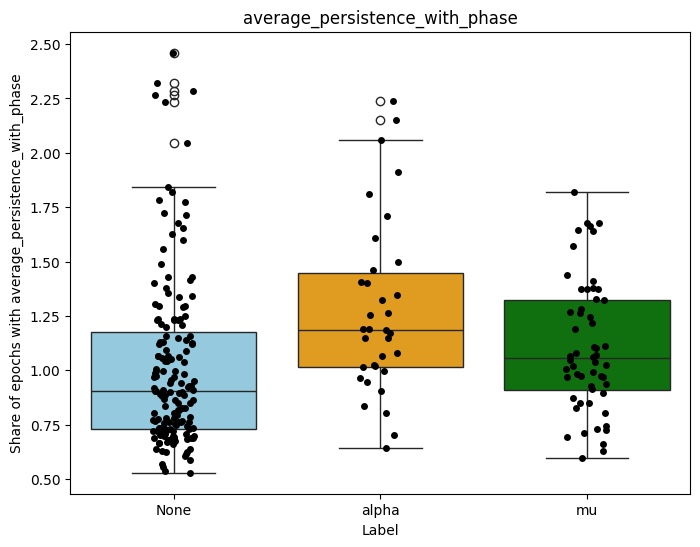

In [23]:
import seaborn as sns
import pandas as pd
import seaborn as sns

# Установим фиксированный seed для случайных чисел
np.random.seed(42)

# Загрузим данные (замени путь на свой)
# features = pd.read_csv('path_to_features.csv', index_col=0)
# targets = pd.read_csv('path_to_targets.csv', index_col=0)

# Соединим датафреймы по индексу
merged_df = mu_rhythm_features_all.join(mu_rhythm_targets_all, how='inner')

# Создадим новый столбец 'Label' для отображения категорий
merged_df['Label'] = 'None'
merged_df.loc[merged_df['flag_alpha'] == True, 'Label'] = 'alpha'
merged_df.loc[merged_df['flag_mu'] == True, 'Label'] = 'mu'

# Определим палитру цветов для каждого боксплота
palette = {"None": "skyblue", "alpha": "orange", "mu": "green"}

# Построим боксплот с разными цветами для каждой категории
plt.figure(figsize=(8,6))
sns.boxplot(data=merged_df, x='Label', y='average_persistence_with_phase', palette=palette)
sns.stripplot(data=merged_df, x='Label', y='average_persistence_with_phase', color='black', jitter=True, dodge=True)
plt.title(f'average_persistence_with_phase')
plt.xlabel('Label')
plt.ylabel('Share of epochs with average_persistence_with_phase')
plt.show()

For training we use XGboost, LinearSVM, and Logistic Regression with default parameters. We do a stratified train-test split with test size = 0.3.

In [24]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

models = {
    'LR': LogisticRegression(solver='liblinear', penalty='l1', C=1.0),
    'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss', use_label_encoder=False),
    'SVM': SVC(C=0.1, kernel='linear', probability=True),
    'CatBoost': CatBoostClassifier(depth=4, iterations=200, learning_rate=0.1, verbose=0),
    'AdaBoost': AdaBoostClassifier(learning_rate=0.5, n_estimators=50)
}
n_repeats = 50


In [25]:
from sklearn.model_selection import train_test_split

def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    y_pred = []
    y_proba = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        y_proba.append(model.predict_proba(X_test)[:, 1])

    return np.array(y_true), np.array(y_pred), np.array(y_proba)


In [30]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, f1_score
def get_aucs(true, proba):
    roc_aucs, pr_aucs = [], []
    for true, proba in zip(y_true, y_proba):
        fpr, tpr, _ = roc_curve(true, proba, drop_intermediate=False)
        prec, rec, _ = precision_recall_curve(true, proba)
        roc_aucs.append(auc(fpr, tpr))
        pr_aucs.append(auc(rec, prec))
    return roc_aucs, pr_aucs

In [31]:
X_train, X_test, y_train, y_test = features['asd'].loc[index_train], features['asd'].loc[index_test], targets_ads_train.loc[index_train], targets_ads_test.loc[index_test]

In [32]:
for flag in ['flag_alpha', 'flag_mu']:
    print(flag)
    y_true = y_test[flag]
    y_pred, y_proba = np.ones(y_test[flag].shape), np.ones(y_test[flag].shape)
    fpr, tpr, _ = roc_curve(y_true, y_proba, drop_intermediate=False)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    print(auc(fpr, tpr))
    print(auc(rec, prec))
    print(f1_score(y_true, y_pred))

flag_alpha
0.5
0.5261437908496732
0.09937888198757763
flag_mu
0.5
0.5261437908496732
0.09937888198757763


In [33]:
from itertools import product
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import pandas as pd

roc_aucs = pd.DataFrame(index=models, columns=['flag_alpha', 'flag_mu'], dtype=float)
pr_aucs = pd.DataFrame(index=models, columns=['flag_alpha', 'flag_mu'], dtype=float)
f1_scores = pd.DataFrame(index=models, columns=['flag_alpha', 'flag_mu'], dtype=float)

columns = list(product(models.keys(), ['flag_alpha', 'flag_mu']))  # Преобразуем в список
asd_predictions = pd.DataFrame(index=targets_ads_test.index, columns=columns, dtype=bool)
asd_predictions[('True Labels', 'flag_alpha')] = targets_ads_test['flag_alpha']
asd_predictions[('True Labels', 'flag_mu')] = targets_ads_test['flag_mu']

for model_name, model in models.items():
    for flag in ['flag_alpha', 'flag_mu']:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(mu_rhythm_features_all)
        X_test = scaler.transform(features['asd'].loc[index_test])
        model.fit(X_train, mu_rhythm_targets_all[flag])
        y_true = targets_ads_test[flag]
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
        
        asd_predictions[(model_name, flag)] = y_pred

        # ROC и PR кривые
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        prec, rec, _ = precision_recall_curve(y_true, y_proba)
        
        # Вычисляем AUC для ROC и PR кривых
        roc_aucs.loc[model_name, flag] = auc(fpr, tpr)
        pr_aucs.loc[model_name, flag] = auc(rec, prec)
        f1_scores.loc[model_name, flag] = f1_score(y_true, y_pred)


/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be remov

In [34]:
asd_predictions.columns = pd.MultiIndex.from_tuples(asd_predictions.columns)

In [35]:
roc_aucs

,flag_alpha,flag_mu
LR,0.980172,0.975000
XGB,0.975862,0.992241
SVM,0.972414,0.977586
CatBoost,0.981897,0.991379
AdaBoost,0.981897,0.975000


In [36]:
pr_aucs

,flag_alpha,flag_mu
LR,0.803796,0.651636
XGB,0.564034,0.843800
SVM,0.726864,0.678722
CatBoost,0.813595,0.868075
AdaBoost,0.755863,0.722244


In [37]:
f1_scores

,flag_alpha,flag_mu
LR,0.666667,0.666667
XGB,0.588235,0.800000
SVM,0.588235,0.736842
CatBoost,0.705882,0.736842
AdaBoost,0.750000,0.588235
